<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [15]</a>'.</span>

## Stock Price Prediction - AnalyticsVidya

You are given 103 stock options from Jan 2017 to Oct 2019, with OHLC data. You need to predict the stock's *Closing* value for the next 2 months.
[Link](https://datahack.analyticsvidhya.com/contest/hacklive-4-guided-community-hackathon)

#### Dataset Columns
1. ID - Unique ID
2. Stock - Stock Option
3. Date - Trading Date
4. Open - Stock's Opening price
5. High - Stock's Highest price that day
6. Low - Stock's Lowest price that day
7. Close - Stock's Closing price (Target)
8. Unpredictability Score - How volatile the Stock is

A time series problem can be solved using 2 different method, statistical or regression


Load the libraries

In [1]:
library(tidyverse)
library(tsibble)
library(fable)
library(feasts)
library(repr)
library(lubridate)
library(furrr)
library(purrr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Loading required package: fabletools


Attaching package: ‘lubridate’


The following object is masked from ‘package:tsibble’:

    interval


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: future



In [2]:
train <- read_csv("../input//hacklive-4/Train.csv")
test <- read_csv("../input//hacklive-4/Test.csv")
sample_sub <- read_csv("../input//hacklive-4/SampleSubmission.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  stock = col_double(),
  Date = col_date(format = ""),
  Open = col_double(),
  High = col_double(),
  Low = col_double(),
  Close = col_double(),
  holiday = col_double(),
  unpredictability_score = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  stock = col_double(),
  Date = col_date(format = ""),
  holiday = col_double(),
  unpredictability_score = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Close = col_double()
)




In [3]:
summary(train)

      ID                stock          Date                 Open       
 Length:73439       Min.   :  0   Min.   :2017-01-03   Min.   : 21.03  
 Class :character   1st Qu.: 25   1st Qu.:2017-09-18   1st Qu.: 50.03  
 Mode  :character   Median : 51   Median :2018-06-04   Median : 69.46  
                    Mean   : 51   Mean   :2018-06-02   Mean   : 75.41  
                    3rd Qu.: 77   3rd Qu.:2019-02-19   3rd Qu.: 94.10  
                    Max.   :102   Max.   :2019-10-31   Max.   :233.85  
      High             Low             Close           holiday      
 Min.   : 21.13   Min.   : 21.04   Min.   : 20.97   Min.   :0.0000  
 1st Qu.: 50.02   1st Qu.: 50.10   1st Qu.: 50.08   1st Qu.:0.0000  
 Median : 69.42   Median : 69.64   Median : 69.50   Median :0.0000  
 Mean   : 75.42   Mean   : 75.56   Mean   : 75.49   Mean   :0.0575  
 3rd Qu.: 94.07   3rd Qu.: 94.33   3rd Qu.: 94.18   3rd Qu.:0.0000  
 Max.   :233.65   Max.   :231.71   Max.   :232.89   Max.   :1.0000  
 unpredictabi

Now lets check how the stock and unpredictabilty scores

In [4]:
stock_pred_chk <- distinct(train,stock,unpredictability_score) %>%
group_by(stock) %>% summarise(cnt=n())
summary(stock_pred_chk)

`summarise()` ungrouping output (override with `.groups` argument)



     stock            cnt   
 Min.   :  0.0   Min.   :1  
 1st Qu.: 25.5   1st Qu.:1  
 Median : 51.0   Median :1  
 Mean   : 51.0   Mean   :1  
 3rd Qu.: 76.5   3rd Qu.:1  
 Max.   :102.0   Max.   :1  

In [5]:
train <- train %>% 
  unite("stock_pred",c("stock","unpredictability_score"),sep = "_",remove = F)

In [6]:
stock_pred_1 <- train %>% 
  group_by(unpredictability_score) %>% 
  filter(row_number()==1) %>% 
  unite("stock_pred",c("stock","unpredictability_score"),sep = "_",remove = F)

Now lets convert the data to ***tsibble*** the best package to work on time series data. unlike other traditional method, where you convert the each stock to univariate time series object

In [7]:
tr_1 <- train %>% 
  select(stock_pred,Date,Close) %>% 
  as_tsibble(.,key="stock_pred")
tr_1 %>% head()

Using `Date` as index variable.



stock_pred,Date,Close
<chr>,<date>,<dbl>
0_7,2017-01-03,82.8101
0_7,2017-01-04,82.9690
0_7,2017-01-05,82.8578
0_7,2017-01-06,82.7385
0_7,2017-01-09,81.8641
0_7,2017-01-10,80.6796


Plot variable not specified, automatically selected `.vars = Close`



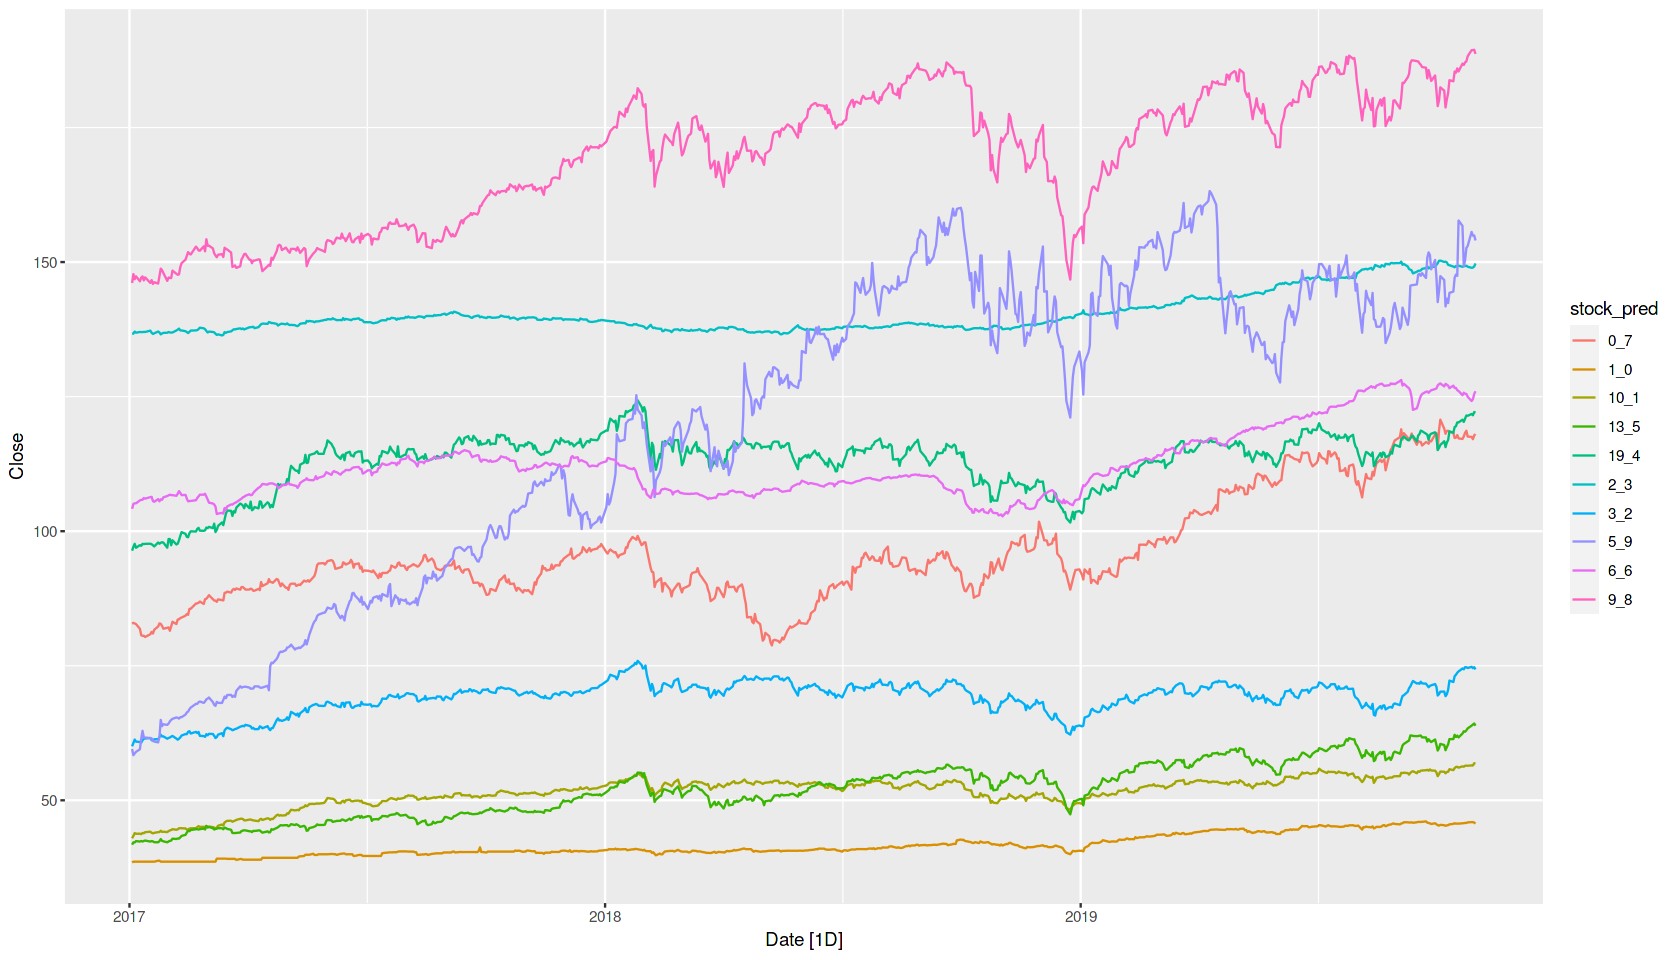

In [8]:
options(repr.plot.width = 14, repr.plot.height = 8)
tr_1 %>% 
  filter(stock_pred %in% stock_pred_1$stock_pred) %>% 
  autoplot()

Plot variable not specified, automatically selected `.vars = Close`



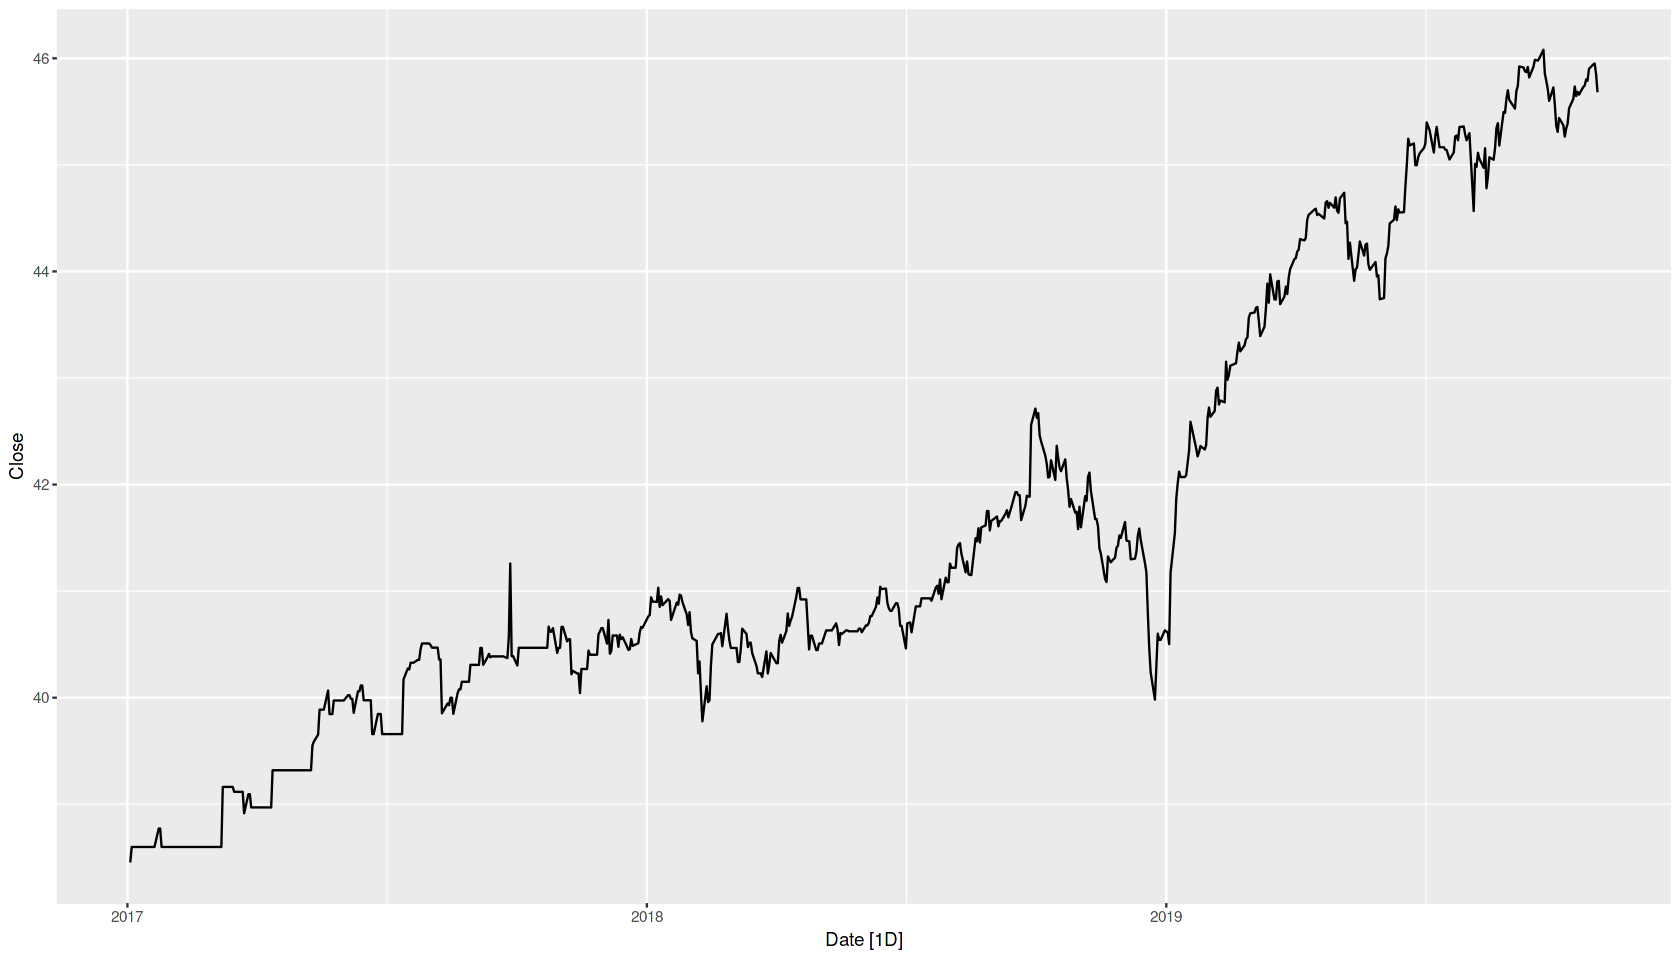

In [9]:
options(repr.plot.width = 14, repr.plot.height = 8)
tr_1 %>% filter(stock_pred=="1_0") %>% 
 autoplot()

In [10]:
tr_1 %>% filter(stock_pred=="1_0") %>%
  ACF(Close) %>% autoplot()

ERROR: Error: .data contains implicit gaps in time. You should check your data and convert implicit gaps into explicit missing values using `tsibble::fill_gaps()` if required.


In [11]:
tr_1 %>% filter(stock_pred=="1_0") %>%
  has_gaps()

stock_pred,.gaps
<chr>,<lgl>
1_0,TRUE


In [12]:
gaps_chk <- tr_1 %>% select(stock_pred,Date) %>% filter(stock_pred=="1_0") %>% mutate(lag_date=lag(Date)) %>%
mutate(Diff_date=Date-lag_date) %>% filter(Diff_date>1) 
gaps_chk %>% head(10)

stock_pred,Date,lag_date,Diff_date
<chr>,<date>,<date>,<drtn>
1_0,2017-01-09,2017-01-06,3 days
1_0,2017-01-17,2017-01-13,4 days
1_0,2017-01-23,2017-01-20,3 days
1_0,2017-01-30,2017-01-27,3 days
1_0,2017-02-06,2017-02-03,3 days
1_0,2017-02-13,2017-02-10,3 days
1_0,2017-02-21,2017-02-17,4 days
1_0,2017-02-27,2017-02-24,3 days
1_0,2017-03-06,2017-03-03,3 days


We cannot use tsibble or any other fable tools like ***ACF()*** or ***PACF()***  or ***STL()*** to perform Time Series Analysis. There is an option where you can fill the implicit dates with ***fill_gaps()*** from **tsibble** package,we can use the Closing price of the Friday as OHLC for Saturday and Sunday. 

But due the to time constrain as I had only 24 hrs left for the competition to end,I had to look for other options. 

### Prophet came to the rescue. 

Ideally Prophet doesnt consider the implicit gaps between the time series. For eg. In time series **a < b < c** ,if **b** is missing then the model can interapolate based on the values in **a** and **c**

In [13]:
install.packages('prophet')
library(prophet)
# f(x) = g(x)+s(x)+h(x)+e

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice




In [14]:
#lets prepare the data
final_tr <- train %>% select(stock,Date,Close) %>% mutate(y=box_cox(Close,lambda = 1)) %>%
  rename("ds"="Date")
final_tr %>% head()

stock,ds,Close,y
<dbl>,<date>,<dbl>,<dbl>
0,2017-01-03,82.8101,81.8101
0,2017-01-04,82.9690,81.9690
0,2017-01-05,82.8578,81.8578
0,2017-01-06,82.7385,81.7385
0,2017-01-09,81.8641,80.8641
0,2017-01-10,80.6796,79.6796


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [15]:
"""
#first instance of running the prophet model

data_collection <- tibble(NULL)

for(ii in distinct_stck$stock){
  #create a subset of the data
  df <- final_tr %>% filter(stock==ii)
  print(paste("============ working on stock",ii,"========= \n",sep = " "))
  m <- prophet::prophet(daily.seasonality = FALSE) #,holidays = holidays
  # m <- add_regressor(m,name = "holiday")
  m <- fit.prophet(m,df)
  print(paste("============ prophet completed for stock",ii,"========= \n",sep = " "))
  future <- make_future_dataframe(m,periods = 90)
  # future <- future %>%
  #   left_join(test_hol,by=c("ds"="Date")) %>%
  #   replace_na(list(holiday=0))
  fcst <- predict(m,future) %>%
    mutate(stock=ii)
  print(paste("============ forecast completed for stock",ii,"========= \n",sep = " "))
  data_collection <- rbind(data_collection,select(fcst,ds,stock,yhat))
  print(paste("============ foreast pasted for stock",ii,"========= \n",sep = " "))
}
"""

ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected string constant
8:   df <- final_tr %>% filter(stock==ii)
9:   print(paste("
     ^


In [16]:
distinct_stck <- distinct(train,stock) %>% as.list()
length(distinct_stck$stock)

[1] 103

### Tidy way

In [17]:
pb <- progress_estimated(length(distinct_stck$stock),0)
final_prophet_all <- final_tr %>% select(stock,ds,y) %>% 
    nest(-stock) %>% 
    mutate(m=map(data,prophet,daily.seasonality=FALSE)) %>%
    mutate(future = map(m,make_future_dataframe,period=61)) %>%
    mutate(forecast = map2(m,future,predict))

Warning message:
“`progress_estimated()` is deprecated as of dplyr 1.0.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“All elements of `...` must be named.
Did you want `data = c(ds, y)`?”


In [18]:
y_chk <- final_prophet_all %>% 
    unnest(forecast) %>% 
    select(ds,stock,yhat)
y_chk %>% head()

ds,stock,yhat
<dttm>,<dbl>,<dbl>
2017-01-03,0,79.89666
2017-01-04,0,79.89877
2017-01-05,0,80.02616
2017-01-06,0,80.16371
2017-01-09,0,80.26760
2017-01-10,0,80.44259


In [19]:
tr_chk <- train %>% 
select(stock,Date,Close) %>% left_join(y_chk,by=c("stock","Date"="ds"))

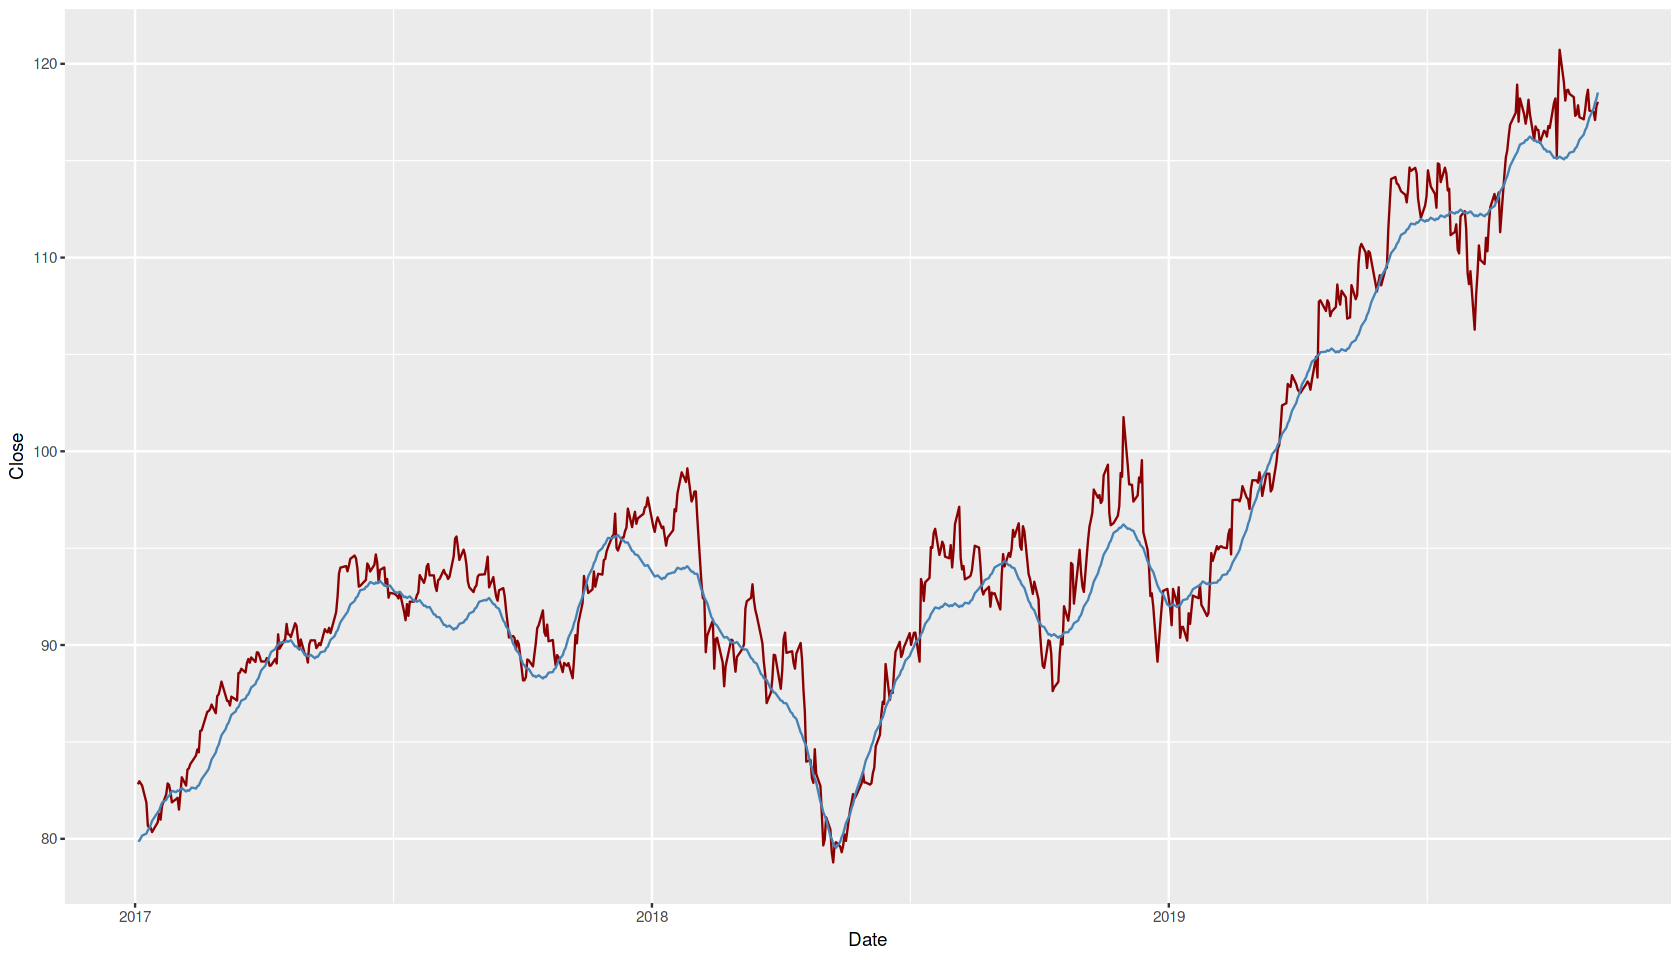

In [20]:
tr_chk %>% filter(stock==0) %>% ggplot(aes(x=Date))+
      geom_line(aes(y=Close),color="darkred")+
      geom_line(aes(y=yhat),color="steelblue")

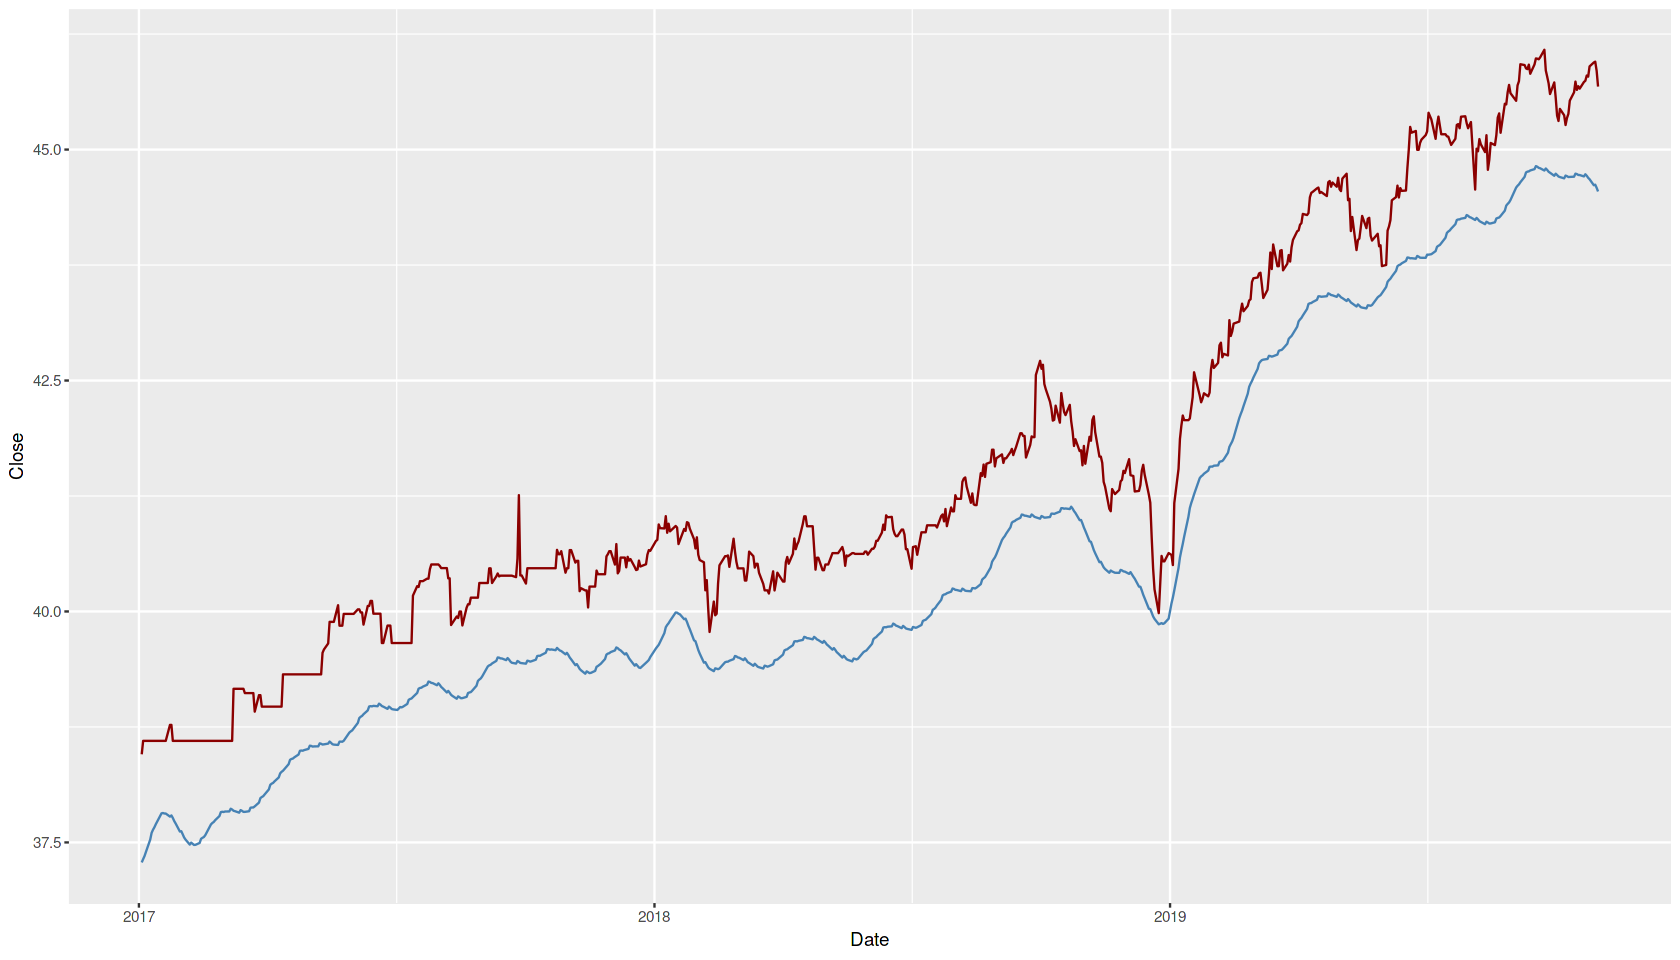

In [21]:
tr_chk %>% filter(stock==1) %>% ggplot(aes(x=Date))+
      geom_line(aes(y=Close),color="darkred")+
      geom_line(aes(y=yhat),color="steelblue")

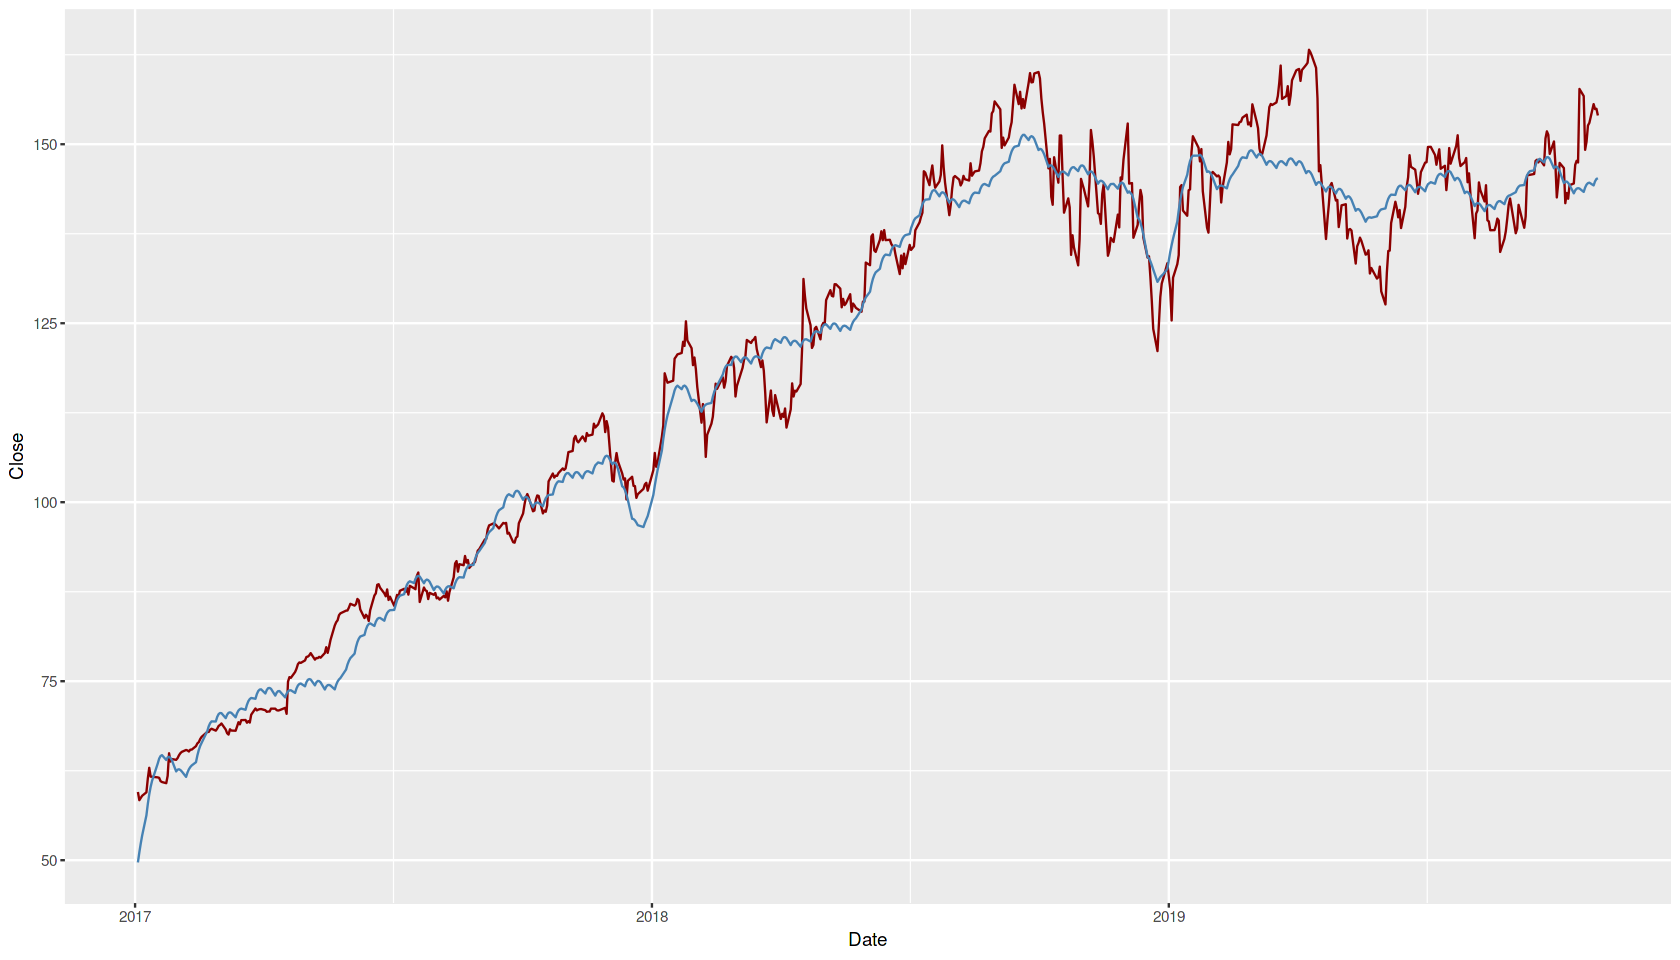

In [22]:
tr_chk %>% filter(stock==5) %>% ggplot(aes(x=Date))+
      geom_line(aes(y=Close),color="darkred")+
      geom_line(aes(y=yhat),color="steelblue")

In [23]:
full <- y_chk %>% left_join(select(train,stock,Date,Close),by=c("stock","ds"="Date")) %>%
    mutate(is_train=if_else(is.na(Close),"Test","Train"),Close=if_else(is.na(Close),yhat,Close))
full %>% head()

ds,stock,yhat,Close,is_train
<dttm>,<dbl>,<dbl>,<dbl>,<chr>
2017-01-03,0,79.89666,82.8101,Train
2017-01-04,0,79.89877,82.9690,Train
2017-01-05,0,80.02616,82.8578,Train
2017-01-06,0,80.16371,82.7385,Train
2017-01-09,0,80.26760,81.8641,Train
2017-01-10,0,80.44259,80.6796,Train


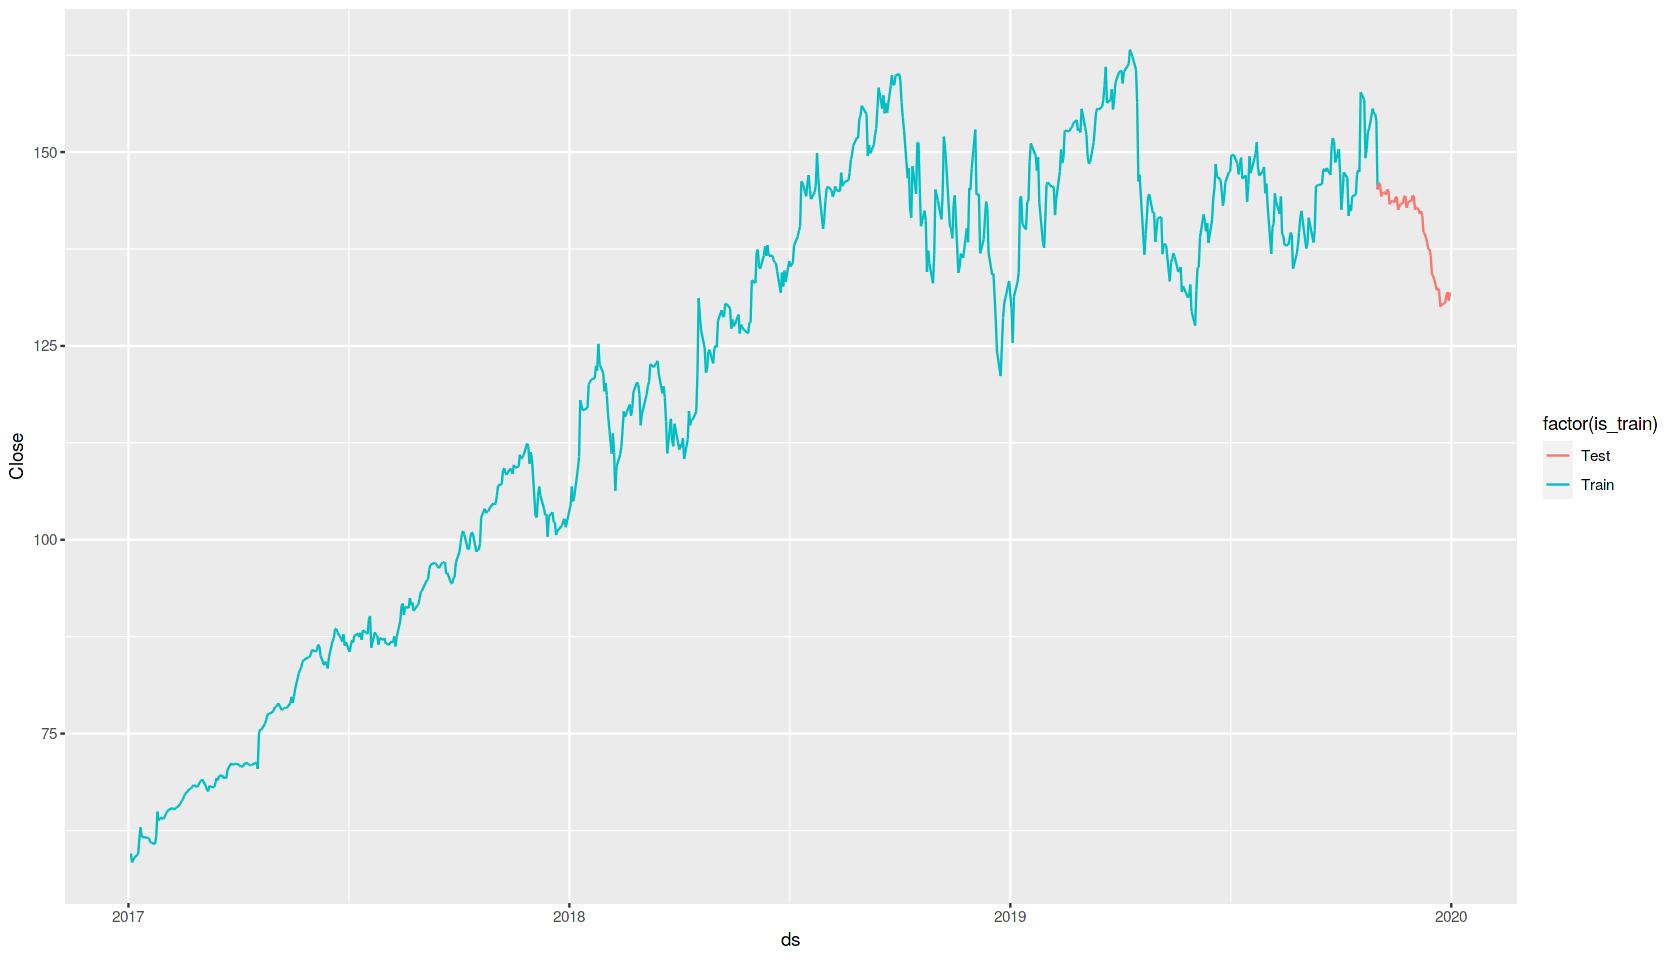

In [24]:
full %>% filter(stock==5) %>% ggplot(aes(x=ds,y=Close,color = factor(is_train)))+
    geom_path(aes(group = 1))

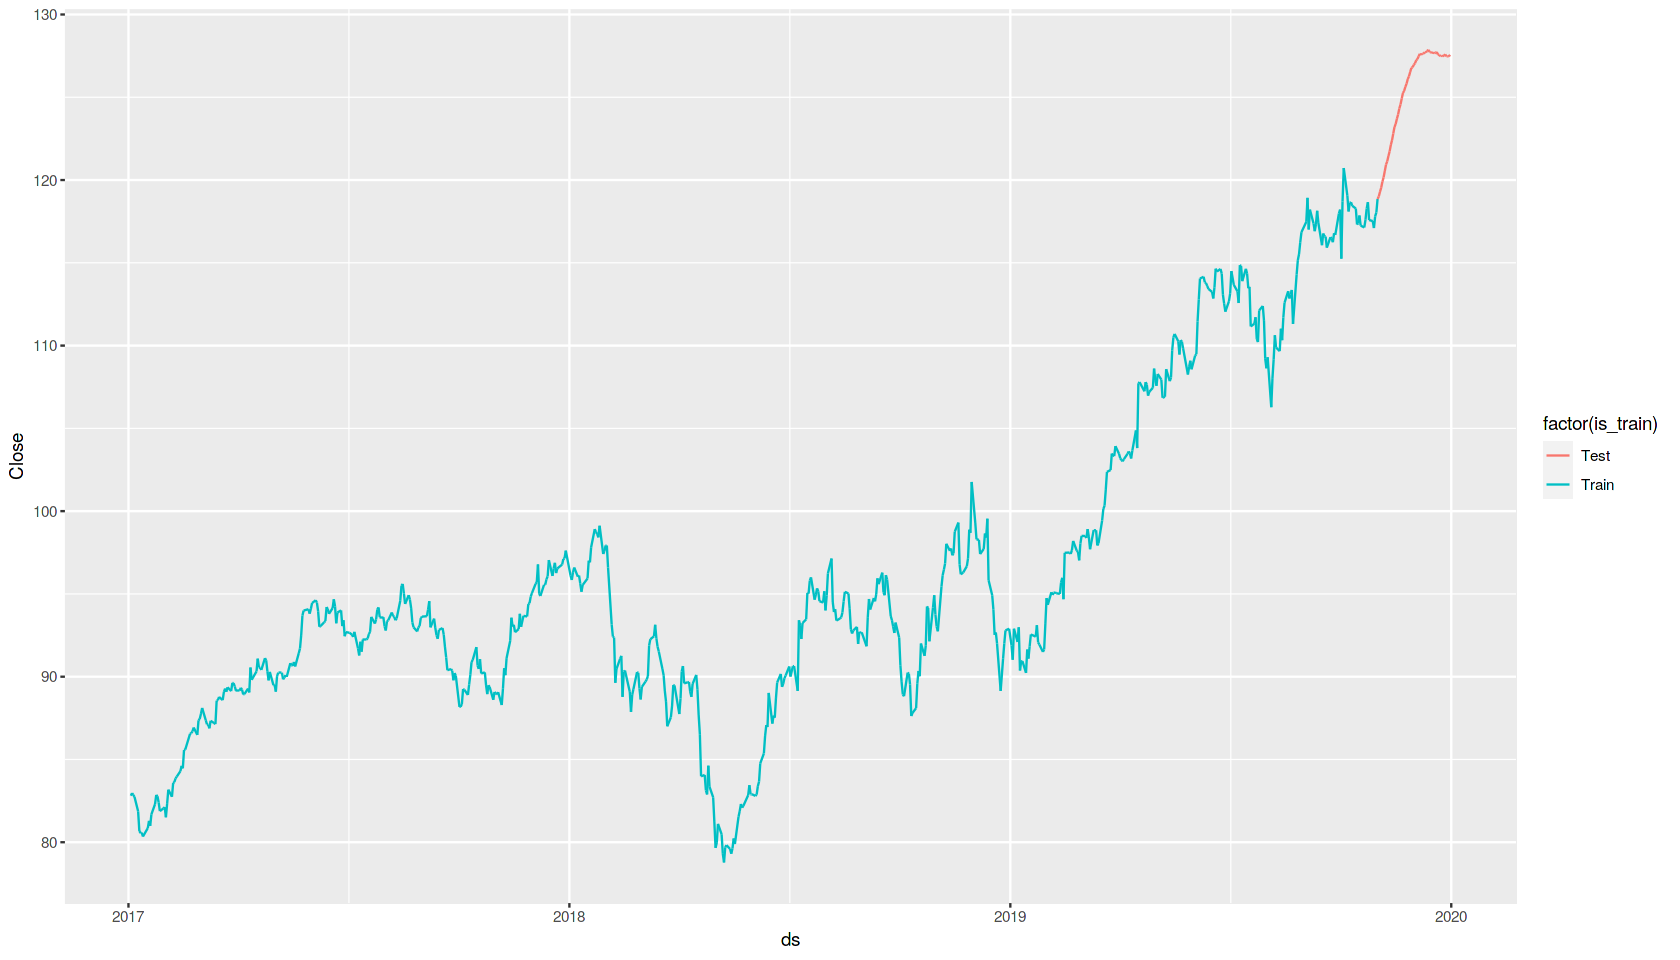

In [25]:
full %>% filter(stock==0) %>% ggplot(aes(x=ds,y=Close,color = factor(is_train)))+
    geom_path(aes(group = 1))

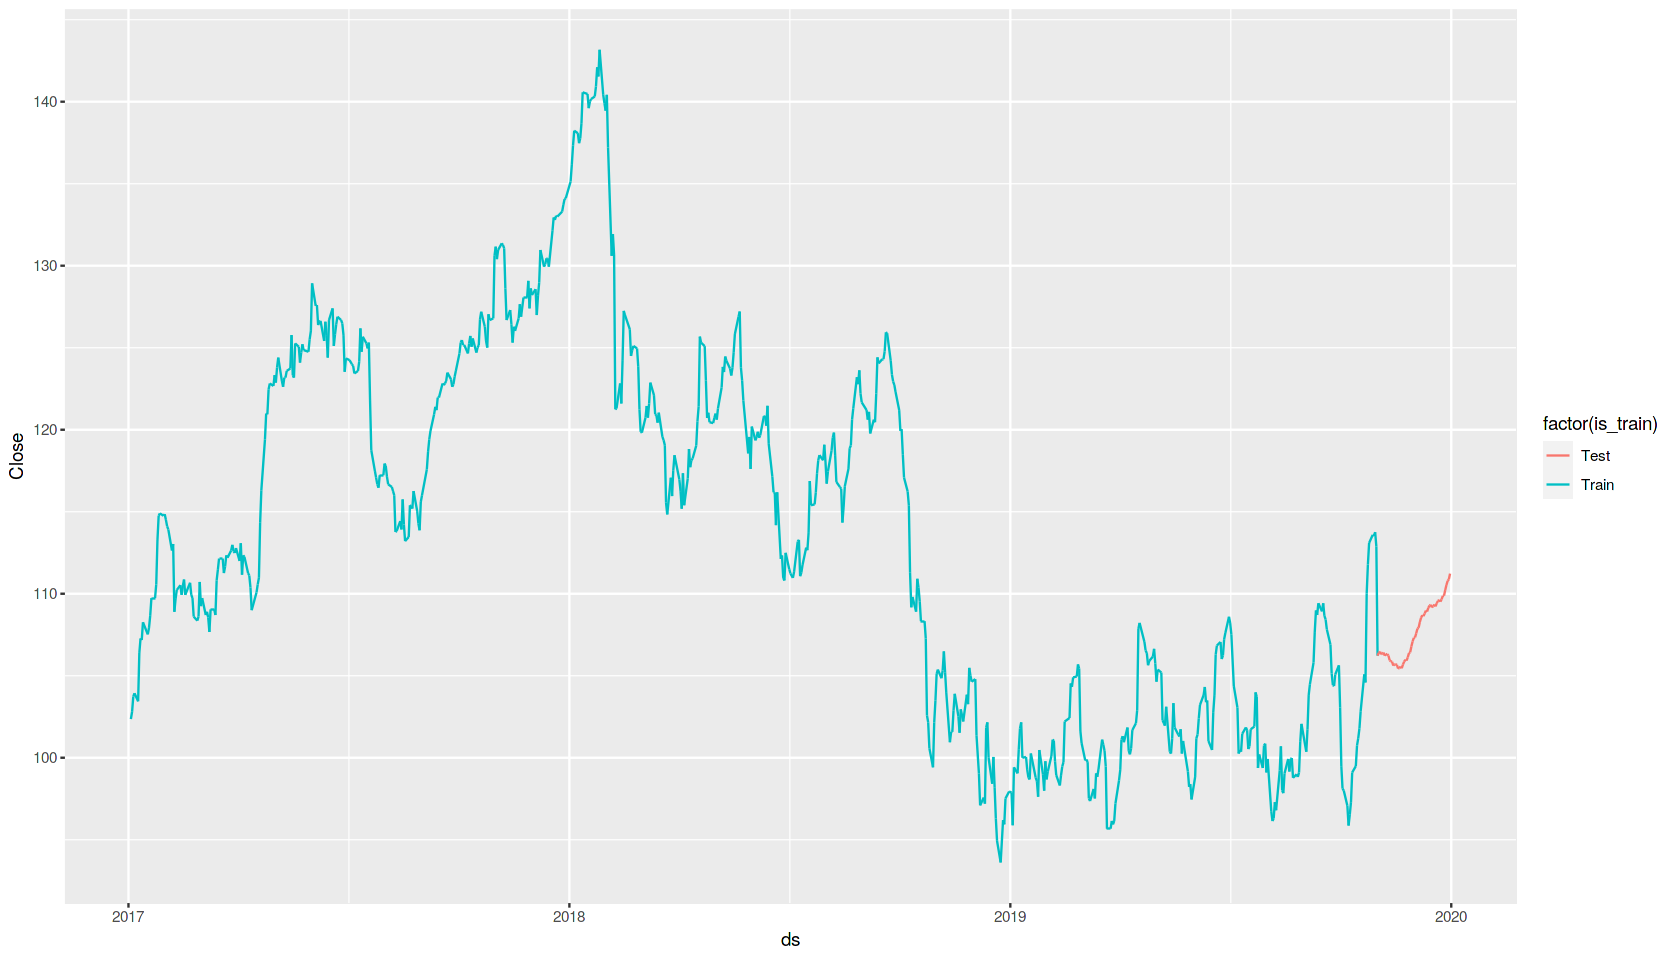

In [26]:
full %>% filter(stock==87) %>% ggplot(aes(x=ds,y=Close,color = factor(is_train)))+
    geom_path(aes(group = 1))

This baseline model predicted a score of ***4.9277*** in Public Leaderboard and ***7.3478*** in Private leaderboard

### Additional Changes made

1. Later, I have transformed the the data using ***Box-Cox*** transformation with ***Lambda=0.3*** and reran the same codes, which gave a prediction of ***3.914*** in Public and ***6.307*** in Private
2. Further more I have added holiday to the prophet, which improved the Public score to ***3.912*** but was ***6.314*** in Private

### Future enhancement (To-do)

1. Predict Open, High, Low using the same process mentioned above for next 61 days and use them as a regressor varibles in Prophet. 
2. Check the reason for underperforming for few Stock & work on Hyperparameter tuning
3. Fix the implicit gaps using fill_gaps() and run traditional models like auto.arima / ets using feasts. Need to check what to be used as OHL for missing dates
4. Create lag values and run LightGBM in python
5. Advance models like 1D CNN / Temporal CNN / LSTM

### If you like this notebook, please do upvote and encourage. Thank you